# DaKanjiRecognizer - Single Kanji CNN : Training
## Setup

Import the needed libraries.

In [1]:
#std lib
import sys
import os
import time
import datetime

#ML
import tensorflow as tf
import numpy as np

from PIL import Image

#plotting/showing graphics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


Because the data sets are big let's make sure that the GPU is available to speed up training.

In [3]:
print("GPUs Available: ", tf.test.gpu_device_name())

GPUs Available:  /device:GPU:0


## Setting up the Data pipeline

Read the labels for each class from file.

In [4]:
labels_1, labels_2, labels = [], [], []

# load labels from file
with open(r'F:\data_sets\etlcdb\encoding_1.txt', mode="r", encoding="utf-8") as f:
    labels_1 = list(eval(f.read()).keys())
with open(r'F:\data_sets\etlcdb\encoding_2.txt', mode="r", encoding="utf-8") as f:
    labels_2 = list(eval(f.read()).keys())
with open(r'F:\data_sets\etlcdb\encoding_3.txt', mode="r", encoding="utf-8") as f:
    labels_3 = list(eval(f.read()).keys())

ls = labels_1 + labels_2 + labels_3
# order the labels
indexs = sorted([str(i) for i in range(0, len(ls))])
ordered_labels = [ls[int(i)] for i in indexs]

# save the labels to text files
with open(r'E:\projects\DaKanjiRecognizerML\single_kanji_cnn\labels_python_list.txt', mode="w+", encoding="utf-8") as f:
    f.write(str(ordered_labels))
with open(r'E:\projects\DaKanjiRecognizerML\single_kanji_cnn\labels.txt', mode="w+", encoding="utf-8") as f:  
    f.write(''.join(ordered_labels))

Create a `tf.keras.dataset` from the saved files for test and validation.

In [5]:
#batch size
bs=512
# class names
classes = [str(i) for i in range(len(labels))]

In [6]:
#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
show_sample_font = fm.FontProperties(fname=os.path.join("..", "fonts", "NotoSerifCJKjp-Regular.otf"), size=20)

def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label, font=show_sample_font)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

## create train dataset

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r'F:\data_sets\etlcdb',
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    color_mode="grayscale",
    batch_size=bs,
    image_size=(64, 64),
    validation_split=0.15,
    subset="training",
    seed=123
)

Found 6770651 files belonging to 6543 classes.
Using 5755054 files for training.


In [8]:
train = train_dataset.map(
    lambda x, y : (tf.cast(x, tf.float16), (tf.cast(y, tf.float16))),
    num_parallel_calls=tf.data.AUTOTUNE
)
train = train.cache(r"F:\data_sets\etlcdb_cache\cache_train")
train = train.shuffle(buffer_size=bs*3)
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)

print(train.take(0))

<TakeDataset shapes: ((None, 64, 64, 1), (None, 6543)), types: (tf.float16, tf.float16)>


## create test dataset

In [9]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=r'F:\data_sets\etlcdb',
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    color_mode="grayscale",
    batch_size=bs,
    image_size=(64, 64),
    validation_split=0.15,
    subset="validation",
    seed=123
)

Found 6770651 files belonging to 6543 classes.
Using 1015597 files for validation.


In [10]:
val = val_dataset.map(
    lambda x, y : (tf.cast(x, tf.float16), (tf.cast(y, tf.float16))),
    num_parallel_calls=tf.data.AUTOTUNE
)
val = val.cache(r"F:\data_sets\etlcdb_cache\cache_test")
val = val.shuffle(buffer_size=bs*3)
val = val.prefetch(buffer_size=tf.data.AUTOTUNE)

print(val.take(0))

<TakeDataset shapes: ((None, 64, 64, 1), (None, 6543)), types: (tf.float16, tf.float16)>


## Defining and training the CNN

In [15]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomZoom, RandomRotation, RandomTranslation

img_augmentation = tf.keras.Sequential(
    [
        # resize images and rescale values
        Resizing(64, 64, "lanczos3"),
        Rescaling(scale=1.0/255),

        # random data augmentation
        RandomZoom(height_factor=(0.0, 1.0), width_factor=(0.0, 1.0), 
            fill_mode='constant', interpolation='bilinear', fill_value=0.0
        ),
        RandomTranslation(0.2, 0.2, fill_mode="constant"),
        RandomRotation(0.1, fill_mode='constant', interpolation='bilinear'),
        
    ],
    name = "img_augmentation"
)

Make sure the image augmentaiton layers are working.

In [ ]:
imgs, lbs = [], []
for images, labels in train.take(1):
    imgs.append(images)

In [20]:
plt.figure(figsize=(10, 10))

for i in range(9):
    augmented_images = img_augmentation(imgs[0])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("float64"), cmap="gray")
    plt.axis("off")

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002CA0E7A9820> (for post_execute):


ValueError: Unsupported dtype

ValueError: Unsupported dtype

<Figure size 720x720 with 9 Axes>

In [18]:
from efficientnet_lite import EfficientNetLiteB0

eff_net_lite = EfficientNetLiteB0(
    include_top=True,
    weights=None,
    input_shape=(64, 64, 1),
    classes=len(ls),
    pooling="max",
    classifier_activation="softmax"
)

In [19]:
eff_net_lite.summary()

Model: "efficientnetlite0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 32, 32, 32)   288         stem_conv_pad[0][0]              
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 32, 32, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________

In [21]:
inputs = tf.keras.layers.Input(shape=(64, 64, 1))
x = img_augmentation(inputs)
outputs = eff_net_lite(x)

f16_model = tf.keras.Model(inputs, outputs, name="EfficientNet")

f16_model.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
img_augmentation (Sequential (None, 64, 64, 1)         0         
_________________________________________________________________
efficientnetlite0 (Functiona (None, 6543)              11794031  
Total params: 11,794,031
Trainable params: 11,752,015
Non-trainable params: 42,016
_________________________________________________________________


In [48]:
#optionally load stored weights to resume training
#f16_model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-24-0.95.hdf5"))

In [22]:
#path where the model should be saved
model_dir = os.path.join(os.getcwd(), "model")
print("model_dir:", model_dir)

model_dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model


Set the optimizer, loss function and compile the model

In [23]:
l_r = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=l_r)

METRICS = [
    'accuracy', 
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

f16_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=METRICS)

Create a learning rate scheduler.

In [24]:
def scheduler(epoch, lr):
    return l_r - ((l_r / 100 * 4) * (epoch // 3))

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
callbacks_list = [scheduler_callback]

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoints setup
filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list.append(checkpoint)

print("checkpoints dir:", filepath)

checkpoints dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5


Optionally enable tensorboard to track the progress of the model.

In [26]:
# load the tensorboard extension
%load_ext tensorboard

# add the tensorboard callback
log_dir = os.path.join(model_dir, "tf", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_list.append(tensorboard_callback)

print("tensorboard log dir:", log_dir)

tensorboard log dir: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\logs\20210621-215529


Finally train the model on the data set (in case of an Interrupt creates checkpoints).

In [ ]:
#train the model
hist = f16_model.fit(
    train,
    validation_data=val,
    epochs=25,
    initial_epoch=0,
    workers=16,
    use_multiprocessing=True,
    callbacks=callbacks_list
)

E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
11241/11241 [==============================] - 3476s 289ms/step - loss: 3.0748 - accuracy: 0.4462 - precision: 0.8393 - recall: 0.3607 - val_loss: 1.8192 - val_accuracy: 0.6245 - val_precision: 0.7696 - val_recall: 0.5675

Epoch 00001: val_accuracy improved from -inf to 0.62452, saving model to E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-01-0.62.hdf5
Epoch 2/25

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
11241/11241 [==============================] - 2473s 217ms/step - loss: 0.6151 - accuracy: 0.8405 - precision: 0.9150 - recall: 0.8007 - val_loss: 0.9900 - val_accuracy: 0.7768 - val_precision: 0.8597 - val_recall: 0.7417

Epoch 00002: val_accuracy improved from 0.62452 to 0.77684, saving model to E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\checkpoints\weights-improvement-02-0.78.hdf5
Epoch 3/25

Epoch 00003: LearningRateSc

## Evaluating the model

After training plot the loss and accuracy for the test and validation sets.

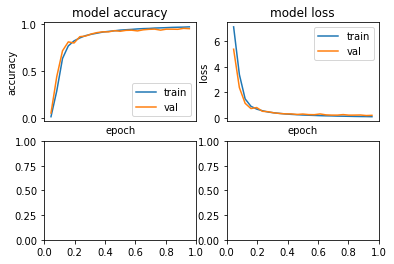

In [64]:
fig, axs = plt.subplots(2, 2)

# accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('model accuracy')
axs[0, 0].set_ylabel('accuracy')
axs[0, 0].set_xlabel('epoch')
axs[0, 0].legend(['train', 'val'], loc='lower right')
axs[0, 0].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

# loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('model loss')
axs[0, 1].set_ylabel('loss')
axs[0, 1].set_xlabel('epoch')
axs[0, 1].legend(['train', 'val'], loc='upper right')
axs[0, 1].tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

The graphs look good.
Let's now make a prediction.

['3', '主', 'シ', '多', '斈', '夛', '芋', '戔', '三', '弖']


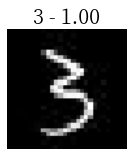

In [67]:
# load a sample
sample = tf.keras.preprocessing.image.load_img(
    path= r"F:\data_sets\etlcdb\6536\5008.jpg",
    color_mode="grayscale",
    target_size=(64, 64)
)

sample = tf.keras.preprocessing.image.img_to_array(sample)
sample = sample.reshape((1, 64, 64, 1)) / 255

# extract EfficientNet and run inference
eff_net = f16_model.get_layer("efficientnetb0")
prediction = eff_net.predict(sample)[0]

# output 10 most liekly predictions
ind = np.argpartition(prediction, -10)[-10:]
q = ind[np.argsort(prediction[ind])]
print([ordered_labels[i] for i in reversed(q)])

# show the most confident prediction and the image
show_image(sample.reshape((64, 64)), ordered_labels[prediction.argmax()] + " - %.2f" % prediction.max())

## Saving the model

The model is perfoming very well therefore save the trained model as a "*.pb" file.

In [68]:
eff_net.save(
    os.path.join(model_dir, "tf", "trained_model"),
)

INFO:tensorflow:Assets written to: E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tf\trained_model\assets


E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Finally convert the model to a TF-Light model to be used in applications.

In [69]:
eff_net.compile(optimizer=opt, loss="categorical_crossentropy", metrics=METRICS)

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(eff_net)

# set quantization
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model.
print(os.path.join(model_dir, "tflite", "model.tflite"))
with open(os.path.join(model_dir, "tflite", "model.tflite"), 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\dario\AppData\Local\Temp\tmp7wviavti\assets


E:\projects\DaKanjiRecognizerML\.venv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


E:\projects\DaKanjiRecognizerML\single_kanji_cnn\model\tflite\model.tflite


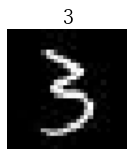

In [70]:
interpreter = tf.lite.Interpreter(os.path.join(model_dir, "tflite", "model.tflite"))
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = sample
interpreter.set_tensor(input_details[0]['index'], input_data)

# run interpreter
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# show prediction
show_image(sample.reshape(64, 64), ordered_labels[output_data.argmax()])